# MATH 250 – Final Project
## Authors: Tanner Van Lear, Drew Dorwin, Paige MacMillan

In [2]:
# Imports and paths setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# data folder
data_path = "/Users/paigemacmillan/Documents/Fall 2025/MATH 250/Project"

# input and output files
vdh_path = data_path + "/vdh-pud-overdose-deaths-by-year-and-geography.csv"
output_path = data_path + "/vdh_overdose_employment_population_full.csv"

### LAUS EMPLOYMENT SPREADSHEETS

In [4]:
# list of the files
laus_files = [
    "laucnty19.xlsx",
    "laucnty20.xlsx",
    "laucnty21.xlsx",
    "laucnty22.xlsx",
    "laucnty23.xlsx",
    "laucnty24.xlsx",
]

# collects cleaned tables from each year
employment_tables = []

# cleaning steps for every spreadsheet
for filename in laus_files:
    # 1. Build the path and read the year's spreadsheet
    laus_path = data_path + "/" + filename
    laus = pd.read_excel(laus_path, header=1)

    # 2. only VA rows (fips = 51)
    laus = laus[laus["State FIPS Code"] == 51].copy()

    # 3. state and county codes
    state_code = laus["State FIPS Code"].astype(int)
    county_code = laus["County FIPS Code"].astype(int)

    # pad the fips parts with zeroes
    laus["state_fips"] = state_code.astype(str).str.zfill(2)
    laus["county_fips"] = county_code.astype(str).str.zfill(3)
    laus["fips"] = laus["state_fips"] + laus["county_fips"]

    # 4. same year column for joining later
    laus["year"] = laus["Year"].astype(int)

    # 5. clean names (drop the ", VA")
    laus["locality_name"] = laus["County Name/State Abbreviation"].astype(str)
    laus["locality_name"] = laus["locality_name"].str.replace(", VA", "", regex=False)

    # 6. rename the columns we care about
    cleaned_laus = laus[
        [
            "fips",
            "year",
            "locality_name",
            "Labor Force",
            "Employed",
            "Unemployed",
            "Unemployment Rate (%)"
        ]
    ].rename(
        columns={
            "Unemployment Rate (%)": "unemployment_rate",
            "Unemployed": "unemployed"
        }
    )

    employment_tables.append(cleaned_laus)

# stack LAUS tables into one
employment = pd.concat(employment_tables, ignore_index=True)

### POPULATION TABLES

In [5]:
# 2010–2019 file
pop_2010_path = (data_path + "/VA-Intercensal-Estimates_2010-2020_UVA-CooperCenter_Updated-2023-01 (1).xlsx")
# 2010–2019 only list
pop_2010_years = list(range(2010, 2020))

#read sheet and skip to rows we need
raw_2010 = pd.read_excel(pop_2010_path, sheet_name="2010-2020 Estimates", skiprows=6)

# keep first three columns + year columns
raw_2010 = raw_2010.iloc[:, : 3 + len(pop_2010_years)]
raw_2010.columns = ["county_fips", "locality_name", "census_value"] + pop_2010_years

# drop footnote rows and build fips
raw_2010["county_fips"] = pd.to_numeric(raw_2010["county_fips"], errors="coerce")

raw_2010 = raw_2010[raw_2010["county_fips"].notna()].copy()
# pad with zeroes
raw_2010["county_fips"] = raw_2010["county_fips"].astype(int).astype(str).str.zfill(3)
# state fips = 51 and build fips
raw_2010["fips"] = "51" + raw_2010["county_fips"]

# wide to long format
pop_2010 = raw_2010.melt(
    id_vars="fips",
    value_vars=pop_2010_years,
    var_name="year",
    value_name="population",
)
pop_2010["population"] = pd.to_numeric(pop_2010["population"], errors="coerce")


# 2020–2024 file
pop_2020_path = data_path + "/VA-Intercensal-Estimates_2020-2024_UVA-CooperCenter (1).xlsx"
#2020-2024 list
pop_2020_years = list(range(2020, 2025))

#read sheet and skip to rows we need
raw_2020 = pd.read_excel(pop_2020_path, sheet_name="Table", skiprows=6)
raw_2020 = raw_2020.iloc[:, : 3 + len(pop_2020_years)]
raw_2020.columns = ["county_fips", "locality_name", "census_value"] + pop_2020_years

raw_2020["county_fips"] = pd.to_numeric(raw_2020["county_fips"], errors="coerce")
raw_2020 = raw_2020[raw_2020["county_fips"].notna()].copy()
#pad with zeroes
raw_2020["county_fips"] = raw_2020["county_fips"].astype(int).astype(str).str.zfill(3)
# state fips = 51 and build fips
raw_2020["fips"] = "51" + raw_2020["county_fips"]

# wide to long format
pop_2020 = raw_2020.melt(
    id_vars="fips",
    value_vars=pop_2020_years,
    var_name="year",
    value_name="population",
)
pop_2020["population"] = pd.to_numeric(pop_2020["population"], errors="coerce")


# COMBINE POP TABLES!!
population = pd.concat([pop_2010, pop_2020], ignore_index=True)

### LOAD VDH OVERDOSE CSV

In [6]:
# load the file
vdh = pd.read_csv(vdh_path)

# keep only locality rows so we can match to counties and cities
vdh = vdh[vdh["Overdose Death Geography Level"] == "Locality"].copy()

# drop rows where geography name is unknown
vdh = vdh[vdh["Overdose Death Geography Name"] != "Unknown"].copy()

# keep only rows for "Any Opioids" so everything is about opioid deaths
vdh = vdh[vdh["Overdose Death Drug Class"] == "Any Opioids"].copy()

# grab the four digit year from strings like "2024^"
vdh["year"] = vdh["Overdose Death Year"].astype(str).str.extract(r"(\d{4})").astype(int)

#drop 2025 rows because we do not have complete data for that year yet
vdh = vdh[vdh["year"] <= 2024]

# clean and pad the fips to make sure every code is five characters
vdh["fips"] = (vdh["Overdose Death FIPS"].astype(str).str.replace(".0", "", regex=False).str.zfill(5))

# turn counts and rates into numbers
vdh["overdose_count"] = pd.to_numeric(vdh["Overdose Death Count"], errors="coerce")
vdh["overdose_rate"] = pd.to_numeric(vdh["Overdose Death Rate per 100,000 Residents"], errors="coerce")

# shorten the long column names so they're easy to read
vdh = vdh.rename(
    columns={
        "Overdose Death Geography Name": "vdh_geography_name",
    }
)

### JOIN ALL SOURCES TOGETHER

In [7]:
# left join overdose table with employment and population by fips and year
merged = vdh.merge(employment, how="left", on=["fips", "year"])
merged = merged.merge(population, how="left", on=["fips", "year"])

# calc deaths per person using the population we just merged in
merged["overdose_per_person"] = merged["overdose_count"] / merged["population"]

#calc unemployed per person using population too
merged["unemployed_per_person"] = merged["unemployed"] / merged["population"]
# list of columns to keep in dataset
keeps = [
    "year",
    "fips",
    "vdh_geography_name",
    "overdose_count",
    "unemployed",
    "unemployment_rate",
    "unemployed_per_person",
    "population",
    "overdose_per_person",
]

# keep only these columns (and in that order)
merged = merged[keeps].copy()

# sort rows in a sensible order
merged.sort_values(["year", "fips"], inplace=True)

# save the analysis table
merged.to_csv(output_path, index=False)

## FIGURES 

In [8]:
# set aesthetic of plots
sns.set(style="whitegrid")

# load and prep
csv_path = "/Users/paigemacmillan/Documents/Fall 2025/MATH 250/Project/vdh_overdose_employment_population_full.csv"

overdose_df = pd.read_csv(csv_path)

#### FIGURE 0: MEAN DEATHS PER PERSON BY YEAR

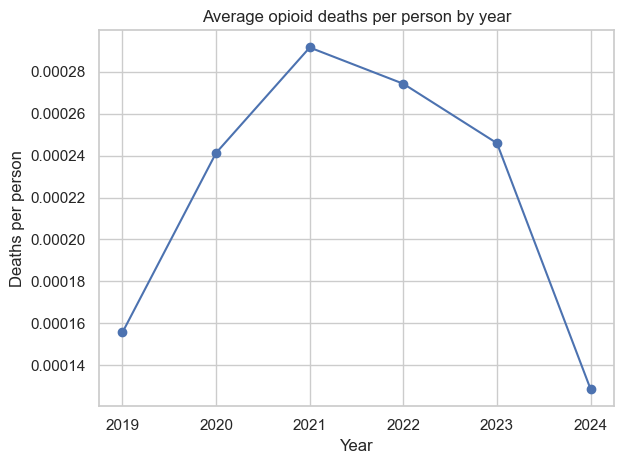

In [9]:
# get the unique years and sort them
years = [2019, 2020, 2021, 2022, 2023, 2024]

# collects means per year values
mean_values = []

# loop over each year and take the mean
for y in years:
    # pick rows for just this year
    this_year_data = overdose_df[overdose_df["year"] == y]["overdose_per_person"]
    # np.mean ignores the index and just works on the values
    mean_values.append(np.mean(this_year_data.values))

# make a small table for plotting
year_mean = pd.DataFrame({"year": years, "overdose_per_person": mean_values})

#plot
plt.figure()
plt.plot(year_mean["year"], year_mean["overdose_per_person"], marker="o")
plt.title("Average opioid deaths per person by year")
plt.xlabel("Year")
plt.ylabel("Deaths per person")
plt.tight_layout()
plt.savefig("fyear_mean_overdose_per_person.png")
plt.show()
plt.close()

#### FIGURE 0.1: OVERALL BOX PLOT OF DEATHS PER PERSON
##### This shows the full distribution across all counties/cities and years combined

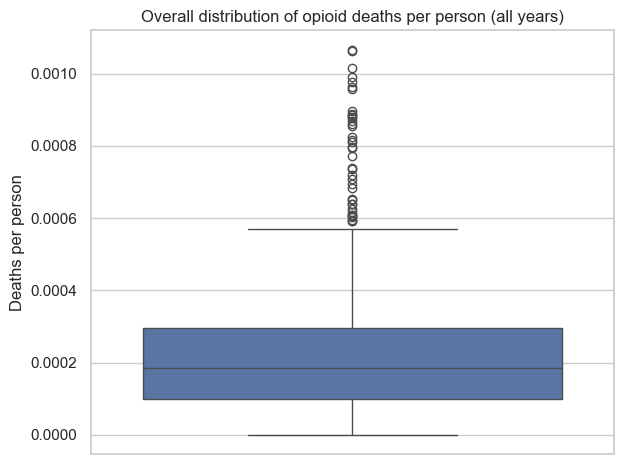

In [10]:
plt.figure()
sns.boxplot(y="overdose_per_person", data=overdose_df)

plt.title("Overall distribution of opioid deaths per person (all years)")
plt.ylabel("Deaths per person")
plt.xlabel("")

plt.tight_layout()
plt.savefig("boxplot_overall_overdose_per_person.png")
plt.show()
plt.close()

#### FIGURE 1.1: BOX PLOT OF DEATHS PER PERSON BY YEAR
##### This shows how spread out the rates are inside each year

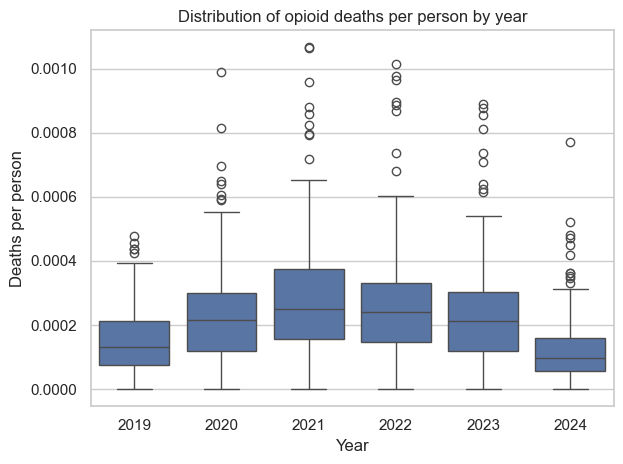

In [11]:
sns.boxplot(x="year", y="overdose_per_person", data=overdose_df)

plt.title("Distribution of opioid deaths per person by year")
plt.xlabel("Year")
plt.ylabel("Deaths per person")

plt.tight_layout()
plt.savefig("boxplot_overdose_per_person.png")
plt.show()

#### OUTLIERS ACROSS YEARS (IQR ON LOCALITY AVERAGES)

In [12]:
# take the mean rate for each county/city across all years
place_mean = overdose_df.groupby("vdh_geography_name")["overdose_per_person"].mean()

Q1 = place_mean.quantile(0.25)
Q3 = place_mean.quantile(0.75)
IQR = Q3 - Q1
cutoff = Q3 + 1.5 * IQR

# any locality with mean above this cutoff is treated as an outlier
outlier_places = place_mean[place_mean > cutoff].sort_values(ascending=False)

print("\nOutlier localities based on IQR (average deaths per person):")
for place_name, mean_rate in outlier_places.items():
    print(place_name, ":", round(mean_rate, 6))


Outlier localities based on IQR (average deaths per person):
Petersburg City : 0.000775
Hopewell City : 0.000717
Richmond City : 0.000659
Portsmouth City : 0.000606
Roanoke City : 0.000599
Henry County : 0.000523
Tazewell County : 0.000462


#### FIGURE 1.2: BOX PLOT WITHOUT OUTLIERS

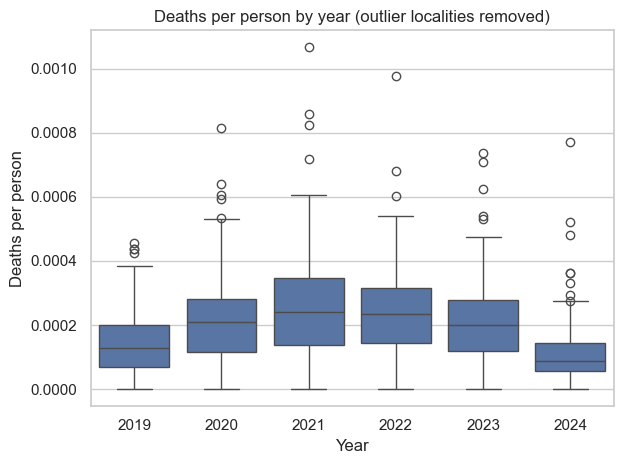

In [13]:
# filter the dataframe to drop any counties/cities that landed in the outlier list
no_outlier_mask = ~overdose_df["vdh_geography_name"].isin(outlier_places.index)
overdose_no_outliers = overdose_df[no_outlier_mask].copy()

plt.figure()
sns.boxplot(x="year", y="overdose_per_person", data=overdose_no_outliers)
plt.title("Deaths per person by year (outlier localities removed)")
plt.xlabel("Year")
plt.ylabel("Deaths per person")
plt.tight_layout()
plt.savefig("fig5_boxplot_no_outliers.png")
plt.show()
plt.close()

#### FIGURE 2: UNEMPLOYMENT VS DEATHS PER PERSON
##### Scatterplot to see if higher unemployment lines up with higher overdose rates

Pearson Correlation Coef:  0.21488953990154613 
R^2:  0.046177514359098185


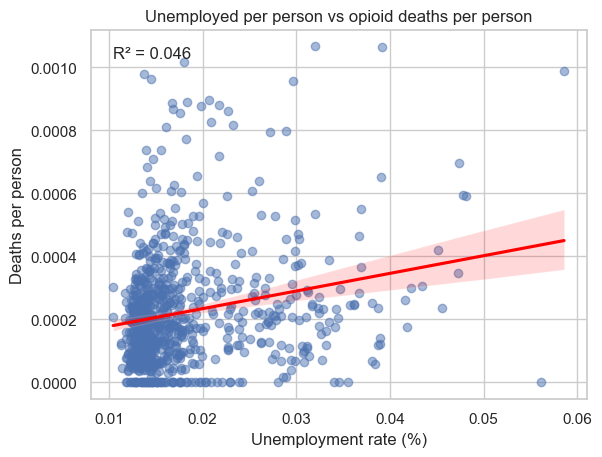

In [14]:
# two columns we need
x = overdose_df["unemployed_per_person"]
y = overdose_df["overdose_per_person"]

# r2 is pearson correlation coef squared
r = np.corrcoef(x, y)[0, 1]
r2 = r ** 2
print("Pearson Correlation Coef: ",r,"\nR^2: ", r2)
plt.figure()
sns.regplot(
    x=x,
    y=y,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
)
# put r2 in the top left
plt.text(
    x.min(),
    y.max(),
    "R² = " + str(round(r2, 3)),
    ha="left",
    va="top",
)
plt.xlabel("Unemployment rate (%)")
plt.ylabel("Deaths per person")
plt.title("Unemployed per person vs opioid deaths per person")
plt.savefig("unemployment_vs_overdose.png")
plt.show()

In [15]:
# DESCRIPTIVE STATISTICS BY YEAR

In [17]:
unemployment_by_year_stats = overdose_df.groupby("year")["unemployment_rate"].describe()

print("\nDescriptive statistics for deaths per person by year:")
print(unemployment_by_year_stats)


Descriptive statistics for deaths per person by year:
      count      mean       std  min  25%  50%  75%   max
year                                                     
2019  133.0  3.215038  0.773862  1.9  2.6  3.0  3.7   5.5
2020  133.0  6.772180  1.640554  4.2  5.7  6.4  7.7  12.8
2021  133.0  4.162406  1.096662  2.6  3.5  3.9  4.7   8.7
2022  133.0  3.027068  0.607544  2.0  2.6  2.9  3.4   4.8
2023  133.0  3.027068  0.600521  2.1  2.6  2.9  3.5   4.9
2024  133.0  3.200752  0.668161  2.2  2.7  3.0  3.6   5.8


In [24]:
# DESCRIPTIVE STATISTICS BY GEOGRAPHY NAME

In [32]:
unemployment_by_geography_stats = overdose_df.groupby("year")["unemployed_per_person"].describe()

unemployment_by_geography_stats_sorted = unemployment_by_geography_stats.sort_index()

print("\nDescriptive statistics for unemployment per person by year:")
print(unemployment_by_geography_stats_sorted)


Descriptive statistics for unemployment per person by year:
      count      mean       std       min       25%       50%       75%  \
year                                                                      
2019  133.0  0.014810  0.002227  0.011298  0.013054  0.014336  0.016113   
2020  133.0  0.030957  0.006912  0.021092  0.026216  0.029834  0.033995   
2021  133.0  0.018860  0.004127  0.013553  0.016165  0.017711  0.020356   
2022  133.0  0.014012  0.001745  0.010463  0.012806  0.013614  0.014856   
2023  133.0  0.014404  0.001840  0.010434  0.013124  0.013975  0.015283   
2024  133.0  0.015194  0.002129  0.011417  0.013773  0.014532  0.016127   

           max  
year            
2019  0.022860  
2020  0.058592  
2021  0.039195  
2022  0.020708  
2023  0.019820  
2024  0.024234  


### MAKING FIGURE 3: MAP GRID
#### SETUP

In [20]:
# make subset
overdose_df = overdose_df.dropna(subset=["overdose_per_person", "year", "fips", "unemployment_rate"])

# make sure FIPS is a 5-character string
overdose_df["fips"] = overdose_df["fips"].astype(str).str.zfill(5)

# load the VA city/county boundaries
shapefile_path = (
    "/Users/tannervanlear/Documents/MATH250_FINAL/Geographic_boundaries/"
    "SDE_USDC_CENSUS_VA_COUNTY_-2322298167389446902/"
    "GIS_DATA_SDE_USDC_CENSUS_VA_COUNTY.shp"
)
va_boundaries = gpd.read_file(shapefile_path)

# build a fips column to match the overdose table and make sure its 5 characters long
va_boundaries["fips"] = va_boundaries["GEOID"].astype(str).str.zfill(5)

# we only need geometry and fips for mapping and make a short name
va = va_boundaries[["fips", "geometry"]].copy()

# max and miv vals for colorbar
vmin = overdose_df["overdose_per_person"].min()
vmax = overdose_df["overdose_per_person"].max()

# list for loop to make grid
map_years = [2019, 2020, 2021, 2022, 2023, 2024]

DataSourceError: /Users/tannervanlear/Documents/MATH250_FINAL/Geographic_boundaries/SDE_USDC_CENSUS_VA_COUNTY_-2322298167389446902/GIS_DATA_SDE_USDC_CENSUS_VA_COUNTY.shp: No such file or directory

#### FIGURE 3: OVERDOSE DEATHS PER PERSON BY YEAR AND LOCALITY MAP GRID

NameError: name 'map_years' is not defined

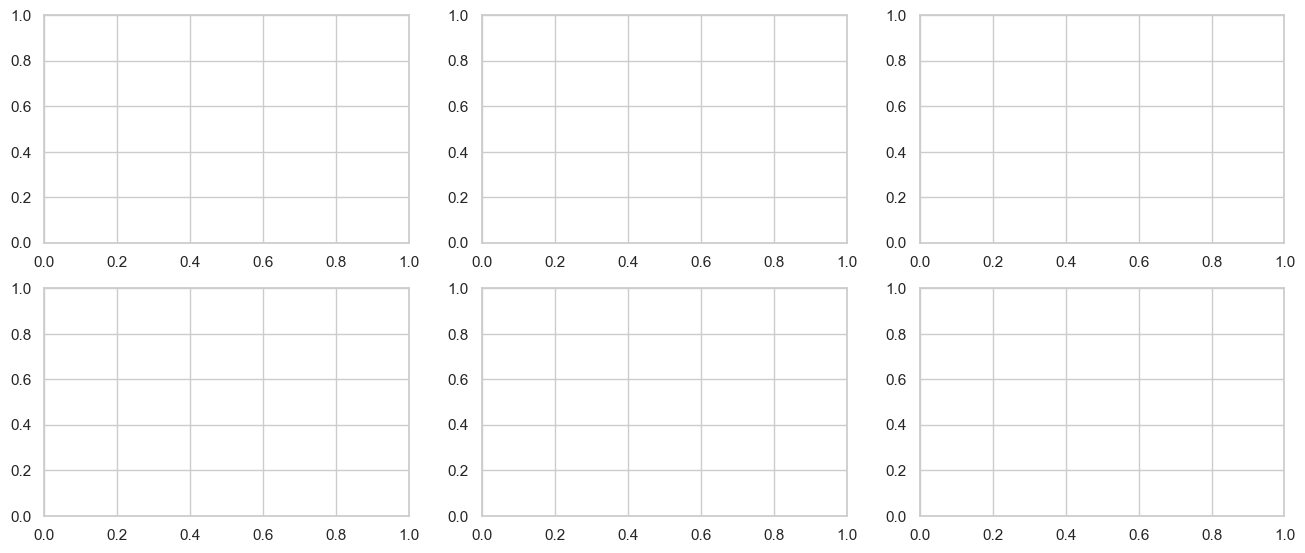

In [19]:
# figure is wide,,, maps should fill most of it
# make a 2x3 grid of maps - one for each year
fig, axes = plt.subplots(2, 3, figsize=(16, 6.5))
map_axes = axes.flatten()

for i in range(len(map_years)):
    this_year = map_years[i]
    ax = map_axes[i]

    # filter overdose table to just this year
    year_data = overdose_df[overdose_df["year"] == this_year]

    # join polygons with overdose values for that year
    year_shapes = va.merge(
        year_data[["fips", "overdose_per_person"]],
        how="left",
        on="fips"
    )

    # draw the map for this year
    year_shapes.plot(
        column="overdose_per_person",
        ax=ax,
        cmap="OrRd",
        vmin=vmin,
        vmax=vmax,
        linewidth=0.12,
        edgecolor="black",
        missing_kwds={"color": "lightgrey", "hatch": "//"}
    )

    ax.set_title(str(this_year))
    ax.set_axis_off()

# shared colorbar that uses the min and max for all years
color_helper = plt.cm.ScalarMappable(cmap="OrRd")
color_helper.set_clim(vmin, vmax)

cbar_ax = fig.add_axes([0.90, 0.16, 0.02, 0.68])
cbar = fig.colorbar(color_helper, cax=cbar_ax)

mid = (vmin + vmax) / 2
cbar.set_ticks([vmin, mid, vmax])
cbar.set_ticklabels([f"{vmin:.6f}", f"{mid:.6f}", f"{vmax:.6f}"])
cbar.set_label("Opioid deaths per person")

fig.suptitle("Virginia opioid overdose deaths per person by year")
plt.savefig("map1_overdose_per_person_by_year_CHECKKK.png", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
# DESCRIPTIVE STATISTICS BY YEAR

In [18]:
by_year_stats = overdose_df.groupby("year")["overdose_per_person"].describe()

print("\nDescriptive statistics for deaths per person by year:")
print(by_year_stats)


Descriptive statistics for deaths per person by year:
      count      mean       std  min       25%       50%       75%       max
year                                                                        
2019  133.0  0.000156  0.000113  0.0  0.000076  0.000132  0.000214  0.000477
2020  133.0  0.000241  0.000176  0.0  0.000118  0.000217  0.000299  0.000990
2021  133.0  0.000292  0.000216  0.0  0.000158  0.000250  0.000374  0.001066
2022  133.0  0.000274  0.000203  0.0  0.000147  0.000242  0.000330  0.001015
2023  133.0  0.000246  0.000185  0.0  0.000120  0.000213  0.000304  0.000889
2024  133.0  0.000129  0.000122  0.0  0.000057  0.000097  0.000161  0.000771
